In [1]:
%matplotlib notebook
%matplotlib inline

import os
import obspy as ob
import obspy.signal

from obspy.clients.fdsn import Client
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyasdf
from scipy.fftpack import rfft, irfft
from pyasdf import ASDFDataSet
from numpy import linalg as lg


# Custom defined functions
from inventory_utils import *
from load_salvus_waveforms import *
from other_utils import *

plt.style.use('default')
mpl.rc('font', **{'size':16})

## The data we'll use is from a SALVUS simulation, meant to model a single impulsive noise source in the Atlantic Ocean, as observed by an array of stations on Iceland. The noise source was to the North East, and consisted of a vertical component ricker-wavelet. To keep the computation time reasonable, the mesh only supports periods of 20-80 seconds, though ambient noise microseism is generally strongest at shorter periods (i.e., 5-15 seconds). 

## The first few cells of this notebook deal with reading in the synthetic waveforms and looking at our array

---------Stream------------
WaveformsZ:
30 Trace(s) in Stream:

XD.HOT01..BHZ | 1969-12-31T23:59:28.812128Z - 1970-01-01T00:16:38.812128Z | 1.0 Hz, 1031 samples
...
(28 other traces)
...
XD.HOT30..BHZ | 1969-12-31T23:59:28.812128Z - 1970-01-01T00:16:38.812128Z | 1.0 Hz, 1031 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]
---------Trace------------
Example: waveformsZ[0]:
         network: XD
         station: HOT01
        location: 
         channel: BHZ
       starttime: 1969-12-31T23:59:28.812128Z
         endtime: 1970-01-01T00:16:38.812128Z
   sampling_rate: 1.0
           delta: 1.0
            npts: 1031
           calib: 1.0
         _format: ASDF
            asdf: AttribDict({'format_version': '1.0.0', 'tag': 'velocity'})
     coordinates: AttribDict({'latitude': 64.494141, 'longitude': -21.167883})
      processing: ["ObsPy 1.2.2: detrend(options={}::type='linear')", "ObsPy 1.2.2: taper(max_length=None::max_percentage=0.05::side='both'::type='cosine

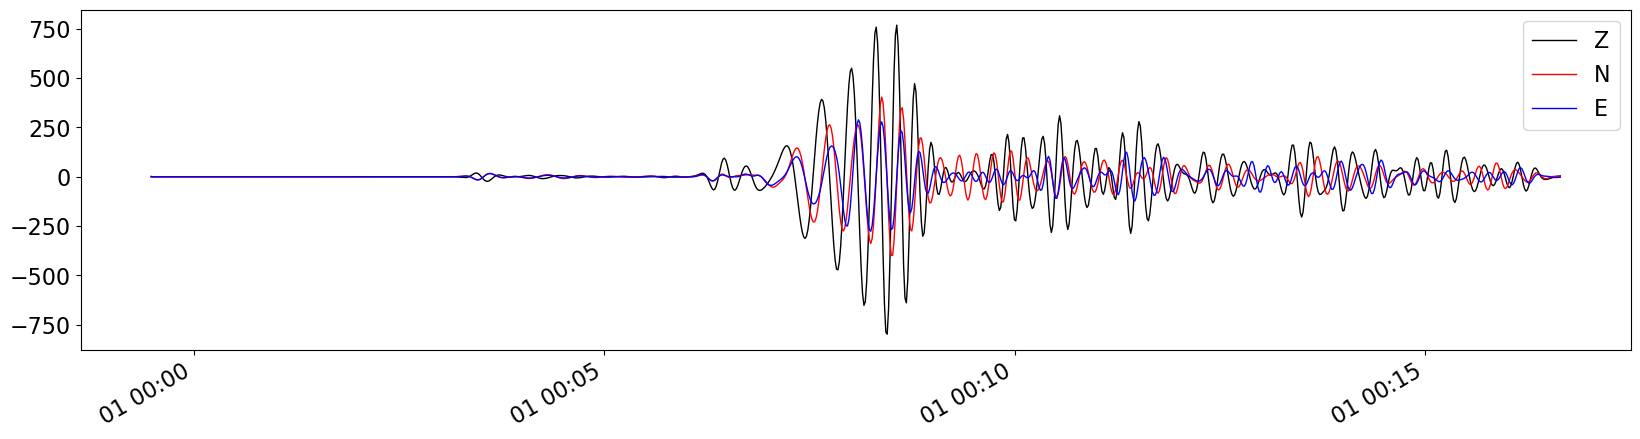

---------waveformsZ.plot(type="section")------------


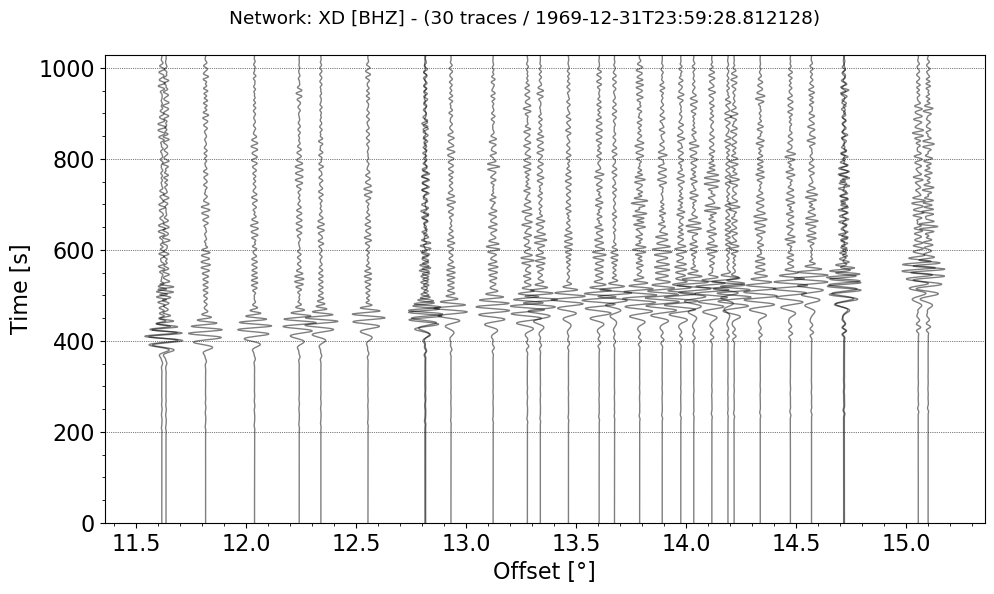

---------Station map--------------------
(30, 3)


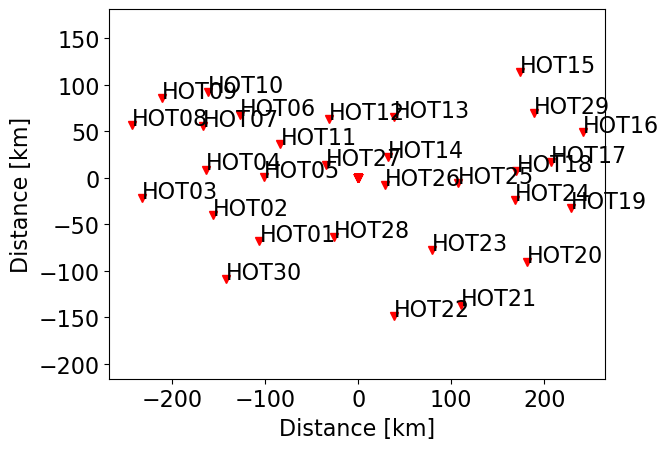

/Users/danielbowden/Dropbox/Codes/Python/Demo_beamforming_salvus/other_utils.py:88: RuntimeWarning: divide by zero encountered in true_divide
  plt.loglog(1/ff, np.abs(spectra))
/Users/danielbowden/Dropbox/Codes/Python/Demo_beamforming_salvus/other_utils.py:90: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([10^-9,10^-3])
/Users/danielbowden/Dropbox/Codes/Python/Demo_beamforming_salvus/other_utils.py:90: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([10^-9,10^-3])


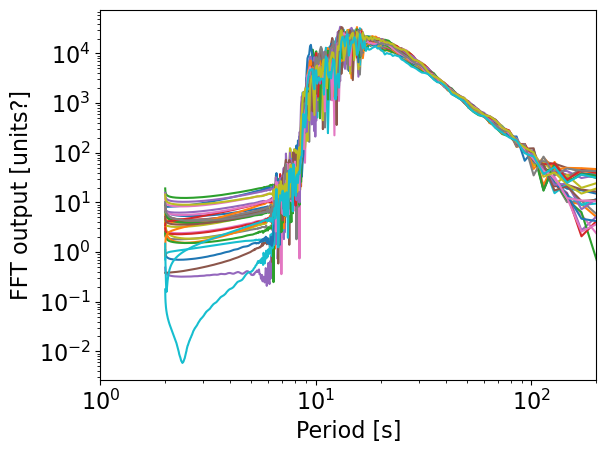

In [2]:
stations, waveformsZ, waveformsN, waveformsE = load_salvus_waveforms(
                                                    'output_onesource_ricker', 
                                                    plot=True, verbose=True)

ff,spectra = get_spectra(waveformsZ, plot=True)
# Note that this simulation was only designed for 20-80 seconds periods.
#  The frequencies outside of this range are unstable!

## A quick back-of-the-envelope check of our array dimensions.
### The bandpass filter of our data should be comparable to the wavelengths/frequencies resolveable by the array aperature and station-spacing.

### In general, beamforming can be used on data that with shorter or longer periods than described here. In the case of shorter periods (high frequency), expect aliasing. In the case of longer periods (low frequency), expect a large "blob" or poor resolution.

### The array-response function (shown at the end) can be useful to characterize an array, and potentially even deconvolved from the resulting image.

In [3]:
nsta = np.shape(stations)[1]

# Get the station locations / distances 
lats = [ sta.latitude for sta in stations[0].stations]
lons = [ sta.longitude for sta in stations[0].stations]
elevs = [ sta.elevation for sta in stations[0].stations]
names = [ sta.code for sta in stations[0].stations]

ref_lat = np.mean(lats)
ref_lon = np.mean(lons)
xx=np.zeros(nsta,)
yy=np.zeros(nsta,)
for i in range(nsta):
    xx[i],yy[i] = ob.signal.util.util_geo_km(ref_lon, ref_lat, lons[i], lats[i])


dis=[]
for i in range(nsta):
    for j in range(nsta):
        if(i==j):
            continue
        dis.append( np.sqrt( (xx[i]-xx[j])**2 + (yy[i]-yy[j])**2 ))
print("Average distance = {0:.2f}km".format(np.mean(dis)))
print("At 3km/s, average period for array = {0:.2f}sec".format(np.mean(dis)/3))
print("")

print("Min distance (inter-station) = {0:.2f}km".format(np.min(dis)))
print("At 3km/s, shortest period = {0:.2f}sec".format(np.min(dis)/3))
print("")


print("Max distance (aperture) = {0:.2f}km".format(np.max(dis)))
print("At 3km/s, longest period = {0:.2f}sec".format(np.max(dis)/3))
print("")


print("Signals bandpassed from {0:.2f} to {1:.2f} seconds".format(20,80))

Average distance = 209.52km
At 3km/s, average period for array = 69.84sec

Min distance (inter-station) = 30.87km
At 3km/s, shortest period = 10.29sec

Max distance (aperture) = 484.84km
At 3km/s, longest period = 161.61sec

Signals bandpassed from 20.00 to 80.00 seconds


## Define a grid of slownesses to test. This is the domain we will grid-search over, to represent every possible plane wave (both direction and speed / slowness)

In [4]:
# max-slowness:
sl=.75 # second/km

# number of pixes in x and y
nux = 51
nuy = 51
ux = np.linspace(-sl,sl,nux)
uy = np.linspace(-sl,sl,nuy)
dux = ux[1]-ux[0]
duy = uy[1]-uy[0]


## We'll setup a quick plotting routine for later

In [5]:
mpl.rc('font', **{'size':20})

def plot_beam(P, title="Beamform",save=0,savename='none',cmax=0):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_axes([0.1,0.1,0.6,0.6])  #x0,y0,dx,dy
    cmap = plt.get_cmap('inferno')
    i = plt.pcolor(ux-dux/2,uy-duy/2,np.abs(P.T),cmap=cmap,rasterized=True)#,vmin=-4,vmax=4)
    if(cmax==0):
        cmax=np.max(P)
    plt.clim(0,cmax)
    plt.axis('equal')
    plt.axis('tight')
    plt.xlim(min(ux)+dux,max(ux)-dux)
    plt.ylim(min(uy)+duy,max(uy)-duy)
    plt.xlabel('Slowness East-West [s/km]')
    plt.ylabel('Slowness North-South [s/km]')
    ax.tick_params(top=True,right=True)
#     plt.plot(sx,sy,'k*')
    plt.plot([np.min(ux), np.max(ux)],[0,0],'k')
    plt.plot([0,0],[np.min(uy), np.max(uy)],'k')
    plt.title(title)
    
    colorbar_ax = fig.add_axes([0.75, 0.1, 0.03, 0.6])  #x0,y0,dx,dy
    fig.colorbar(i, cax=colorbar_ax)

    if(save==1):
        plt.savefig(savename, bbox_inches='tight')
    plt.show()

### There's a few different versions of the beamforming algorithm in this notebook. We'll start with time-domain:


# 1) Beamform - time domain! Apply shifts to waveforms, measure correlations.
### This is maybe the easiest to understand, because we can visualize timeshifts directly. 

In [6]:
# Pull data into a straight numpy array for easier use later
nsamp = np.size(waveformsZ[0].data)
sr = waveformsZ[0].stats.sampling_rate
dt = 1/sr

# For now we'll only work with vertical component data
data = np.zeros([nsamp,nsta])
for ii in range(nsta):
    data[:,ii] = waveformsZ[ii].data



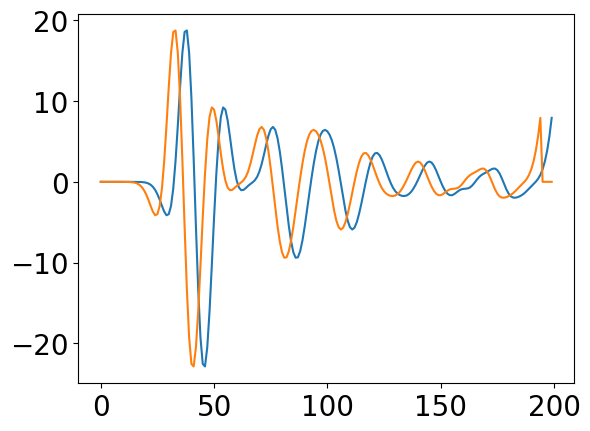

In [7]:
# To apply time-shifts, we'll use the function "specshift"
# Just a quick check to see that this works
data_slice = data[200:400,0]
plt.plot(data_slice)

shifts = 5/dt # seconds, converted to # of samples

data_shifted = spec_shift(data_slice,shifts)
plt.plot(data_shifted)

plt.show()




# Specshift works by transforming into frequency domain, applying a phase shift
# and transforming back. It's probably over-engineered and inefficient for our use
# but I'm using it here because I'm too lazy to deal with zero-padding the edges.

## Even within simple time-domain beamforming, there's a couple different ways people write it:
## Version 1a: Bartlett processor. For a given possible slowness (incident planewave), loop through each station-station combination, apply a timeshift to one or the other, measure correlation: 
\begin{equation*}
P(s_x, s_y) = \sum_{i}\sum_{j} C^{obs}_{ij}(\Delta t_{ij}).
\end{equation*}

starting gridpoints: 2601
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
done!


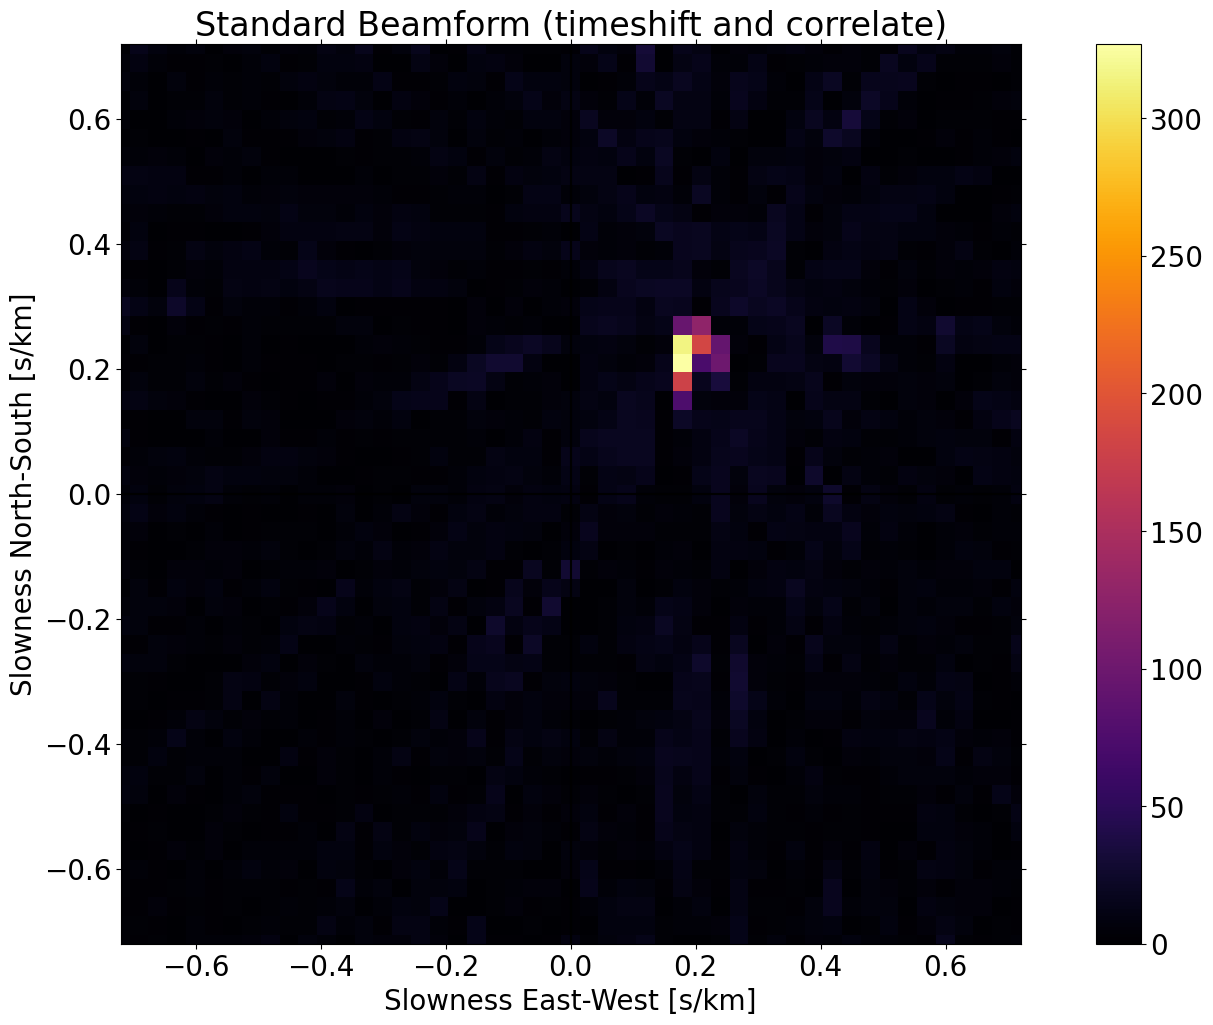

In [28]:
# CAUTION! This is very slow... 
P1a = np.zeros([nux,nuy])


counter_grid = 0
print("starting gridpoints: {0}".format(nux*nuy))

# First, a gridsearch over gridpoints in slowness domain
#  A given slowness represents a plane wave, both in azimuth of propagation
#  and in the speed at which it travels.
for ix in range(0,nux):
    for iy in range(0,nuy):
        counter_grid+=1
        if(counter_grid % 1000 == 0):
            print(counter_grid)

        # Now we gridsearch over station pairs
        for i in range(nsta):
            for j in range(nsta):
                if(i==j):
                    continue
                timeshift = (xx[i]-xx[j])*ux[ix] + (yy[i]-yy[j])*uy[iy]
                d1 = np.ravel(spec_shift(data[:,i],-timeshift/dt))
                d2 = data[:,j]
                C = np.corrcoef(d1.T,d2.T) # C will be a 2x2 array
                P1a[ix,iy] += C[0,1]
print('done!')
plot_beam(P1a,title="Standard Beamform (timeshift and correlate)",save=1,savename="standard_beamform_1a.pdf")

## Version 1b: Accomplishes exactly the same thing, but in a more efficient way. Rather than loop through every possible timeshift, we instead define a center point to the array, timeshifting everything to that centerpoint. In this case, the variables "xx" and "yy" are already defined relative to some origin point. Once all the traces are shifted to the origin, we can measure all the correlations at once in a matrix, $R_{xx}$.

starting gridpoints: 2601
1000
2000
done!


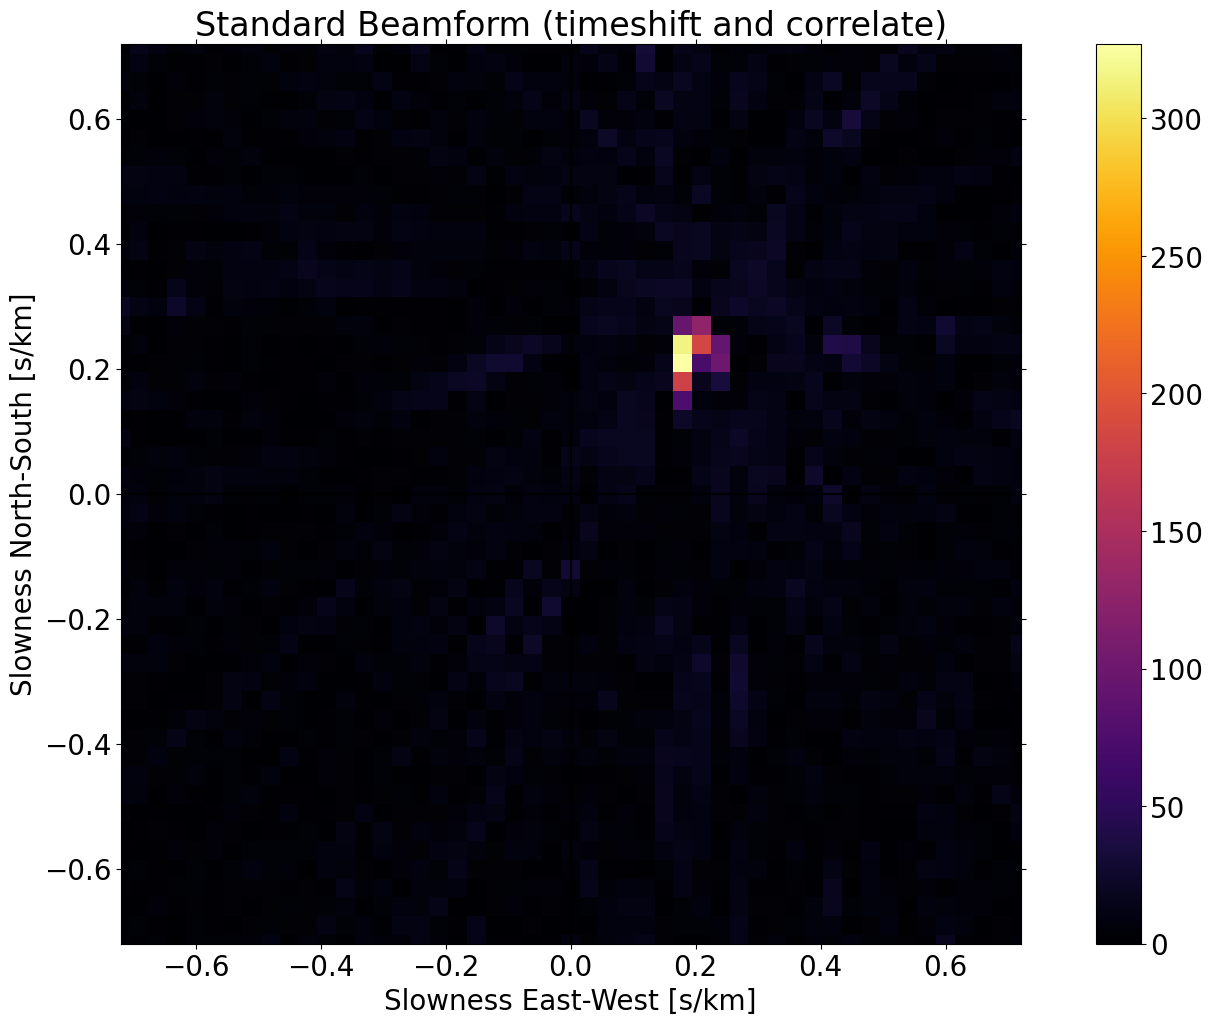

In [8]:
P1b = np.zeros([nux,nuy])

counter_grid = 0
print("starting gridpoints: {0}".format(nux*nuy))
for ix in range(0,nux):
    for iy in range(0,nuy):
        counter_grid+=1
        if(counter_grid % 1000 == 0):
            print(counter_grid)

        timeshifts = xx*ux[ix] + yy*uy[iy]

        dshift = spec_shift(data,-timeshifts/dt)
        Rxx = np.corrcoef(dshift.T)
        np.fill_diagonal(Rxx,0) # Exclude autocorrelations
        P1b[ix,iy] = np.sum( Rxx )#/np.size(Rxx)
print('done!')
plot_beam(P1b,title="Standard Beamform (timeshift and correlate)",save=1,savename="standard_beamform_1b.pdf")

## Version 1c: Delay-and-sum. 
### The versions of beamforming throughout this notebook use a correlation score between waveforms. But some authors traditionally have used a more simple and robust stacking of waveforms. 

### One advantage is that you can preserve absolute units. If you wish to comment on the actual energy present in some plane-wave, the normalized correlations don't work. If you knew the units of your seismograms (i.e., Strain, Displacement, Velocity, etc.), you might make the units should match that of a power spectrum. Power spectra are often shown in relative decibels, i.e.,:
\begin{equation*}
Power = 10* \log_{10}( \frac{P}{P_{max}} )
\end{equation*}

### This simulation data was not scaled properly to an earthquake source, so the units are meaningless in this example

starting gridpoints: 2601
1000
2000
done!


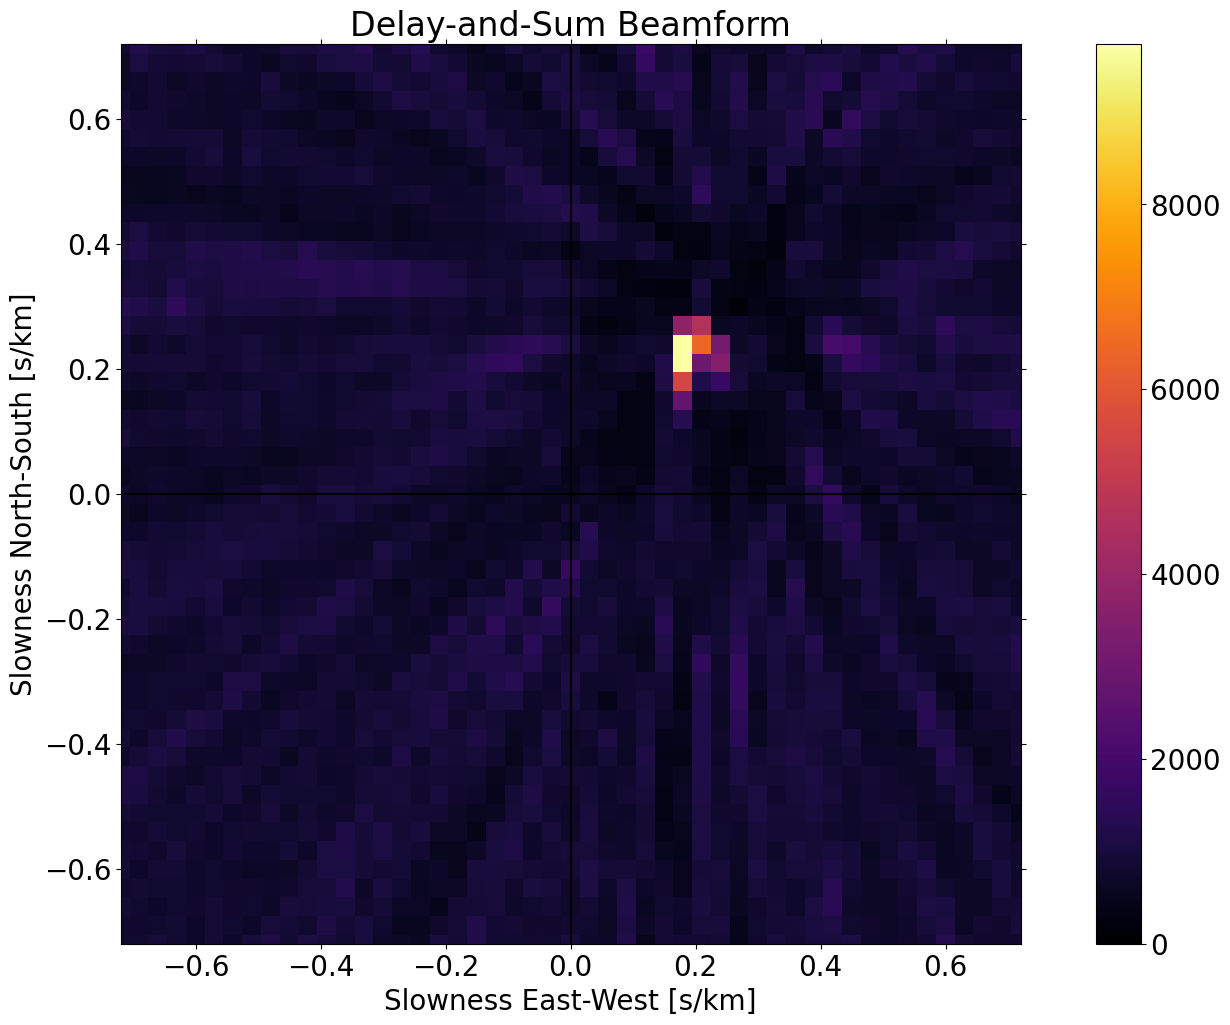

In [9]:
P1c = np.zeros([nux,nuy])

counter_grid = 0
print("starting gridpoints: {0}".format(nux*nuy))
for ix in range(0,nux):
        for iy in range(0,nuy):
                counter_grid+=1
                if(counter_grid % 1000 == 0):
                    print(counter_grid)
                 
                timeshifts = xx*ux[ix] + yy*uy[iy]
                
                dshift = spec_shift(data,-timeshifts/dt)
                stack  = np.sum(dshift,axis=1)/np.shape(dshift)[1]
                P1c[ix,iy] = np.sum(stack**2)/(np.shape(dshift)[0]*sr)
                
print('done!')
plot_beam(P1c,title="Delay-and-Sum Beamform",save=1,savename="delay_and_sum_1c.pdf")

## Version 2: Frequency domain!
### This is computationally faster! We *start* by measuring a correlation matrix, "$R_{xx}$", without any timeshifts. As we gridsearch through possible source slownesses, any timeshift can be represented as a phase delay or "steering vector": $a = e^{(-i 2 pi f \Delta t)}$, where t is the propagation time to some arbitrary reference point (usually the center of the array).

\begin{equation*}
R_{ij}(f) = C^{obs}_{ij}(f)\\
P(f,s_x, s_y) = a^H R a
\end{equation*}
### where $a^H$ denotes a conjugate transpose. Note that in the matrix formulation above, we effectively apply phase delays ($a_i$ and $a_j$) appropriate to both signals ($u_i$ and $u_j$):
\begin{equation*}
a_i R_{ij} a_j = a_i^* u_i^* u_j a_j
\end{equation*}

### ---------------------------------------
### One other note - you need to pick a frequency. *If* you're only interested in a single dominant frequency, this is *a lot* faster than the time-domain versions. If you want something broadband, you'll need to run multiple frequencies and average. 
### How many frequencies? Ideally the same as your frequency sampling in an FFT, but probably that's more than anyone really uses. We'll use 100.
### Also - keep in mind that we're measuring a correlation coefficient, normalized to 1, for each frequency. So if one frequency is stronger in amplitude in the raw signals, this won't be reflected in the average of beamforms. This is similar to "spectral whitening" in ambient noise applications


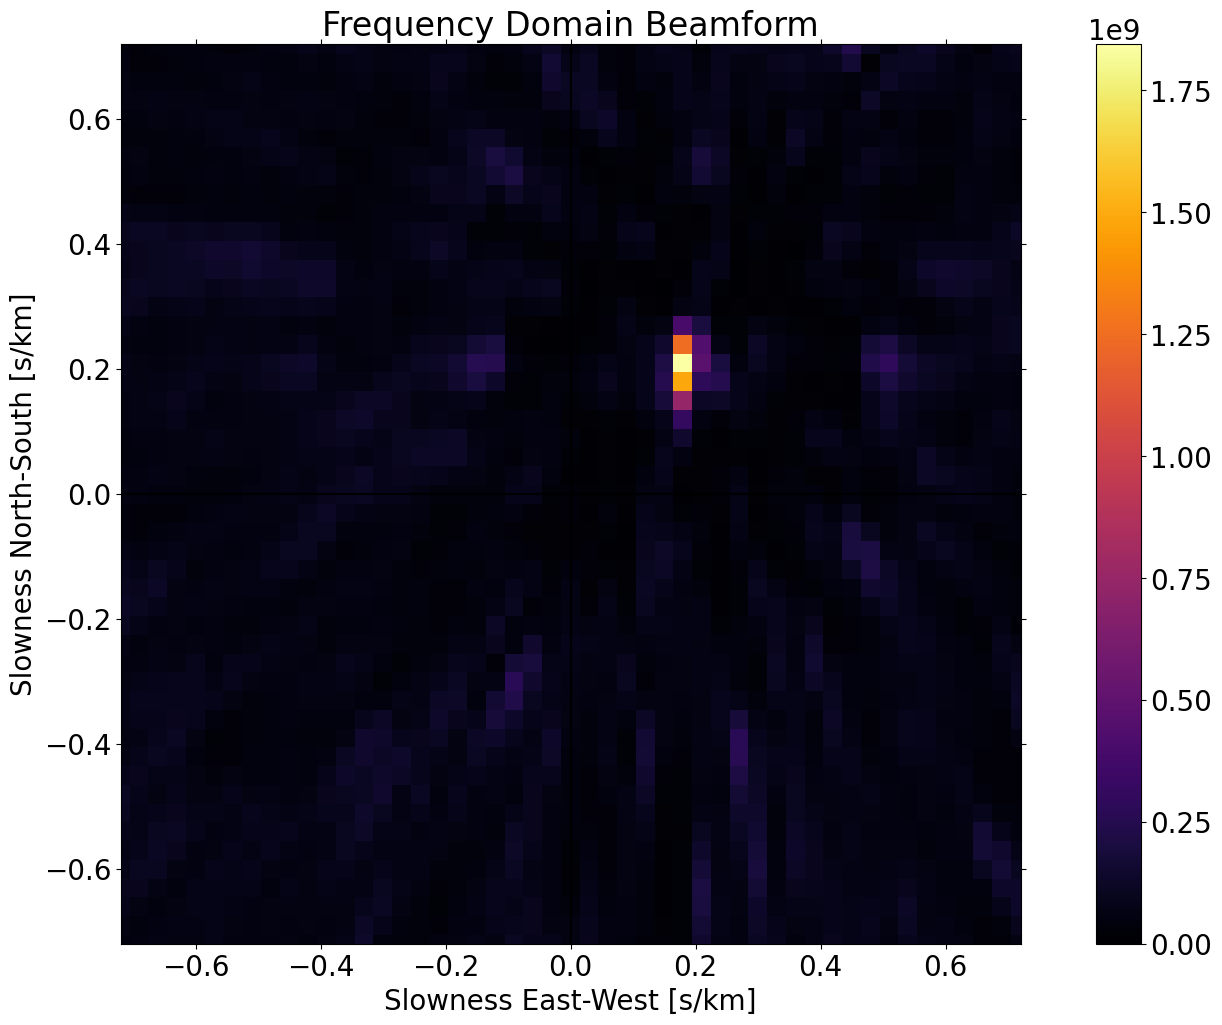

In [12]:

# Let's average the results of several frequencies
num_freqs = 50
t_min = 20
t_max = 80
target_freqs = np.linspace(1/t_max,1/t_min,num_freqs)
# target_periods = np.linspace(20,80,num_periods)

P2 = np.zeros([num_freqs,nux,nuy],dtype=complex)

# To speed things up, let's precompute a library of timeshifts, rather than recompute for each frequency:
tlib=np.zeros([nsta,nux,nuy],dtype=float)
for ix in range(0,nux):
        for iy in range(0,nux):
            tlib[:,ix,iy] = xx*ux[ix] + yy*uy[iy]

for ii in range(np.size(target_freqs)):
    #target_f = 1/target_periods[ii]
    target_f = target_freqs[ii]
    idf = (np.abs(ff - target_f)).argmin()

    # Construct a matrix of each station-station correlation
    Rxx=np.zeros([nsta,nsta],dtype=complex)
    for i1 in range(0,nsta):
        for i2 in range(0,nsta):
            Rxx[i1,i2] = np.conj(spectra[idf,i1]) * spectra[idf,i2]


    for ix in range(0,nux):
            for iy in range(0,nux):
                    timeshifts = tlib[:,ix,iy]

                    a = np.exp(-1j*2*np.pi*target_f*timeshifts)
                    aconj = np.conj(a)
                    P2[ii,ix,iy] = aconj @ Rxx @ a / (aconj @ a)

# Now we average the results from each frequency
P2_stack = np.sum(P2,axis=0)/num_freqs
P2_stack = np.real(P2_stack)

# # Alternatively, normalize the intensity of each period before averaging:
# Pbeam_norm=np.zeros([num_freqs,nux,nuy],dtype=complex)
# for ip in range(np.size(target_freqs)):
#     Pbeam_norm[ip,:,:] = Pbeam[ip,:,:] / np.sum(np.abs(Pbeam[ip,:,:]))
# P2_norm = Pbeam_norm/num_freqs
# P2_norm = np.real(Pbeam_norm)

plot_beam(P2_stack,title="Frequency Domain Beamform",save=1,savename="freq_domain_beamform_2.pdf")

## Version 2 bonus - MUSIC 
## (actually, this performs worse for clean synthetic data, but try it on real data)
### Numerous math "tricks" have been developed to improve the image resolution of frequency-domain beamforming. One example is the MUSIC algorithm, which takes advantage of an eigenvalue decomposition of the correlation matrix, $R_{xx}$.
### Specifically, we use an eigenvalue decomposition to separate the stronger "signal subspace" from the "noise subspace". Exactly where to draw this cutoff / separation is up to the user. 


### It might be intuitive to use the signal subspace:
\begin{equation*}
P(f,s_x, s_y) = \frac{a^H R_{signal} a}{a^H a}
\end{equation*}

###  Actually it is mathematically more robust to look for all signals orthogonal to the noise subspace. That is, rather than ask "what are the strongest signals?" we ask "what are *all* the signals that are *not* noise?" Below is the actual MUSIC algorithm:
\begin{equation*}
P(f,s_x, s_y) = \frac{a^H a}{a^H R_{noise} a}
\end{equation*}

### Probably some similar tricks could be applied to time-domain versions of beamforming, backprojection, MFP, or noise-source inversion, but I have not seen these developed...

[ 0.0125      0.01326531  0.01403061  0.01479592  0.01556122  0.01632653
  0.01709184  0.01785714  0.01862245  0.01938776  0.02015306  0.02091837
  0.02168367  0.02244898  0.02321429  0.02397959  0.0247449   0.0255102
  0.02627551  0.02704082  0.02780612  0.02857143  0.02933673  0.03010204
  0.03086735  0.03163265  0.03239796  0.03316327  0.03392857  0.03469388
  0.03545918  0.03622449  0.0369898   0.0377551   0.03852041  0.03928571
  0.04005102  0.04081633  0.04158163  0.04234694  0.04311224  0.04387755
  0.04464286  0.04540816  0.04617347  0.04693878  0.04770408  0.04846939
  0.04923469  0.05      ]


/anaconda3/envs/obspy3/lib/python3.7/site-packages/ipykernel_launcher.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/envs/obspy3/lib/python3.7/site-packages/ipykernel_launcher.py:48: ComplexWarning: Casting complex values to real discards the imaginary part


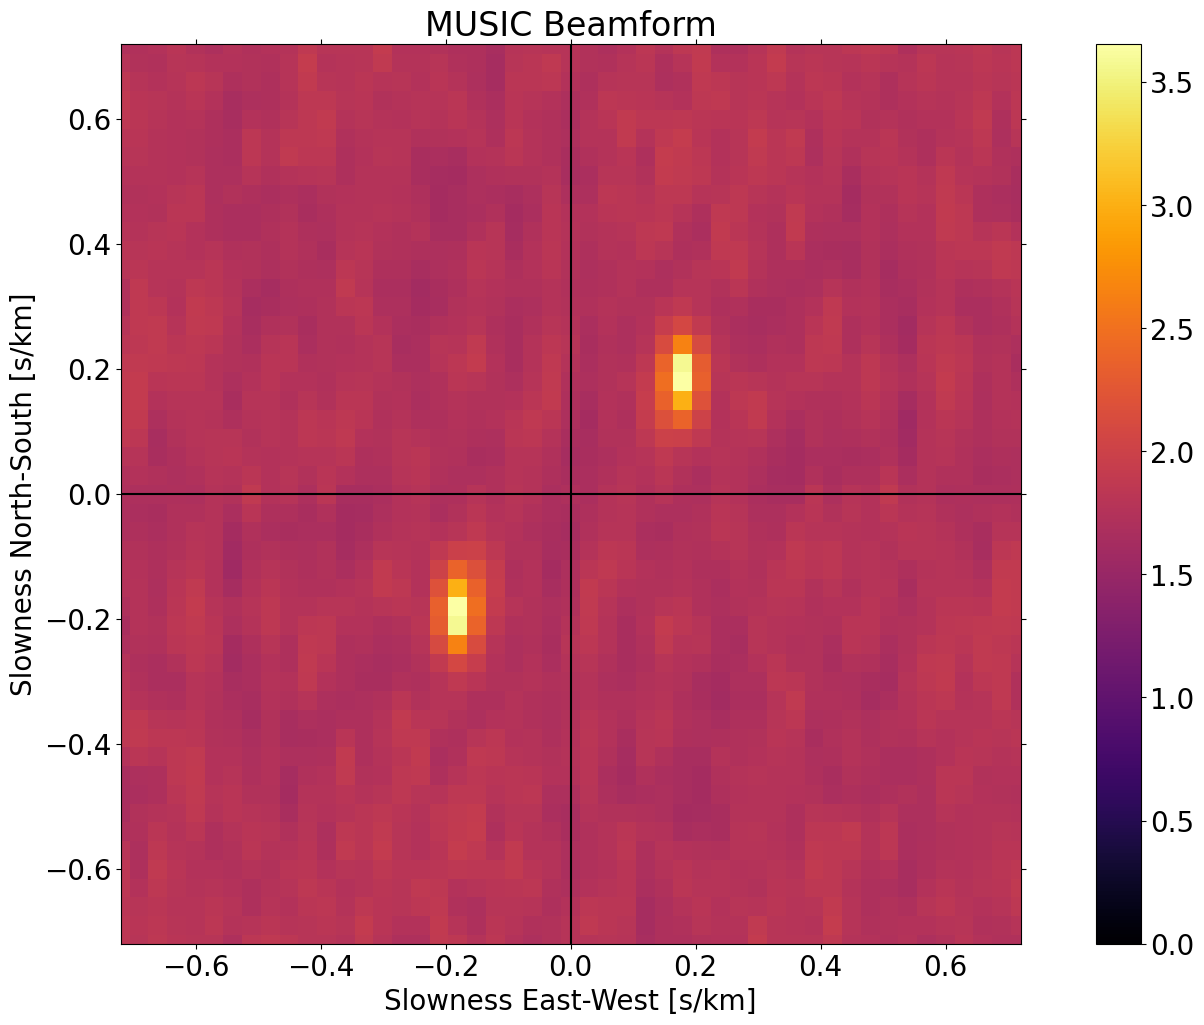

In [14]:
from numpy import linalg as lg
    
    
# Let's average the results of several frequencies
num_freqs = 50
t_min = 20
t_max = 80
target_freqs = np.linspace(1/t_max,1/t_min,num_freqs)
print(target_freqs)
# target_periods = np.linspace(20,80,num_periods)

P2MUSIC = np.zeros([num_freqs,nux,nuy],dtype=complex)

# To speed things up, let's precompute a library of timeshifts, rather than recompute for each frequency:
tlib=np.zeros([nsta,nux,nuy],dtype=float)
for ix in range(0,nux):
        for iy in range(0,nux):
            tlib[:,ix,iy] = xx*ux[ix] + yy*uy[iy]

for ii in range(np.size(target_freqs)):
    #target_f = 1/target_periods[ii]
    target_f = target_freqs[ii]
    idf = (np.abs(ff - target_f)).argmin()

    # Construct a matrix of each station-station correlation
    Rxx=np.zeros([nsta,nsta],dtype=complex)
    for i1 in range(0,nsta):
        for i2 in range(0,nsta):
            Rxx[i1,i2] = np.conj(spectra[idf,i1]) * spectra[idf,i2]

    ######################################
    #- Eigenvalue decomposition
    eig_vals, eig_vecs = np.linalg.eig(Rxx)

    eig_vals_sorted = np.sort(eig_vals)
    eig_vecs_sorted = eig_vecs[:, eig_vals.argsort()]
#     plt.plot(eig_vals_sorted)


    # To determine where to cutoff the "signal" from "noise", we'll use the default value in numpy's matrix_rank() function.
    M = lg.matrix_rank(Rxx)

    # Define R_signal as the last M eigenvectors, and the R_noise as the rest.
    r_signal = np.zeros([nsta,nsta])
    r_signal[:,0:M] = eig_vecs_sorted[:,nsta-M:nsta]

    r_noise  = np.zeros([nsta,nsta])
    r_noise[:,0:nsta-M] = eig_vecs_sorted[:,0:nsta-M]

    # r_noise and r_signal are just arrangements of eigenvectors.
    # To properly reconstruct a matrix like Rxx:
    R_noise = np.dot(r_noise,np.conj(r_noise.T))
    ######################################


    for ix in range(0,nux):
            for iy in range(0,nux):
                    timeshifts = tlib[:,ix,iy]

                    a = np.exp(-1j*2*np.pi*target_f*timeshifts)
                    aconj = np.conj(a)
                    P2MUSIC[ii,ix,iy]= (aconj @ a) / (aconj @ R_noise @ a)

# Now we average the results from each frequency
P2MUSIC_stack = np.sum(P2MUSIC,axis=0)/num_freqs
P2MUSIC_stack = np.real(P2MUSIC_stack)

plot_beam(P2MUSIC_stack,title="MUSIC Beamform",save=0,savename="music_beamform_2.pdf")

         

## Version 3: Correlate, then beamform.
### This is back to time-domain as in 1a, but similar to the frequency domain version above, we will precompute our cross-correlations.  We collect the full cross-correlation vector for every station-station pair in an NxM matrix, where N is the number of pairs and M is 2*maxlag.
### Then, for a given timeshift, $\Delta t_{ij}$, we can deduce where to look in the precomputed correlations.
\begin{equation*}
P(s_x,s_y) = \sum_{i,j} \int\delta(t - \Delta t_{ij})\,C^{obs}_{ij}(t) \,dt.
\end{equation*}

Will compute 900 pairs, keeping +/- 200 seconds of correlation
freq-domain correlations -> "ccf" size: (513, 900)
time-domain correlations -> "cct" size: (400, 900)
(-1.1904767745935807, 518.46559217258573)
172.821864058


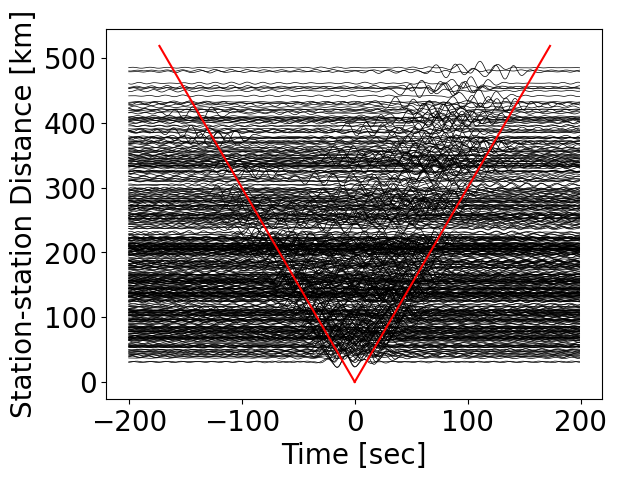

In [15]:
# First, compute the cross correlations for every pair. "ccf" and "cct" hold the freq- and time-domain versions, respectively
ff,ccf,tt,cct,xx,yy,pair_names = cross_correlate(waveformsZ, stations, verbose=True, plot=True)

starting gridpoints: 2601
1000
2000
done!


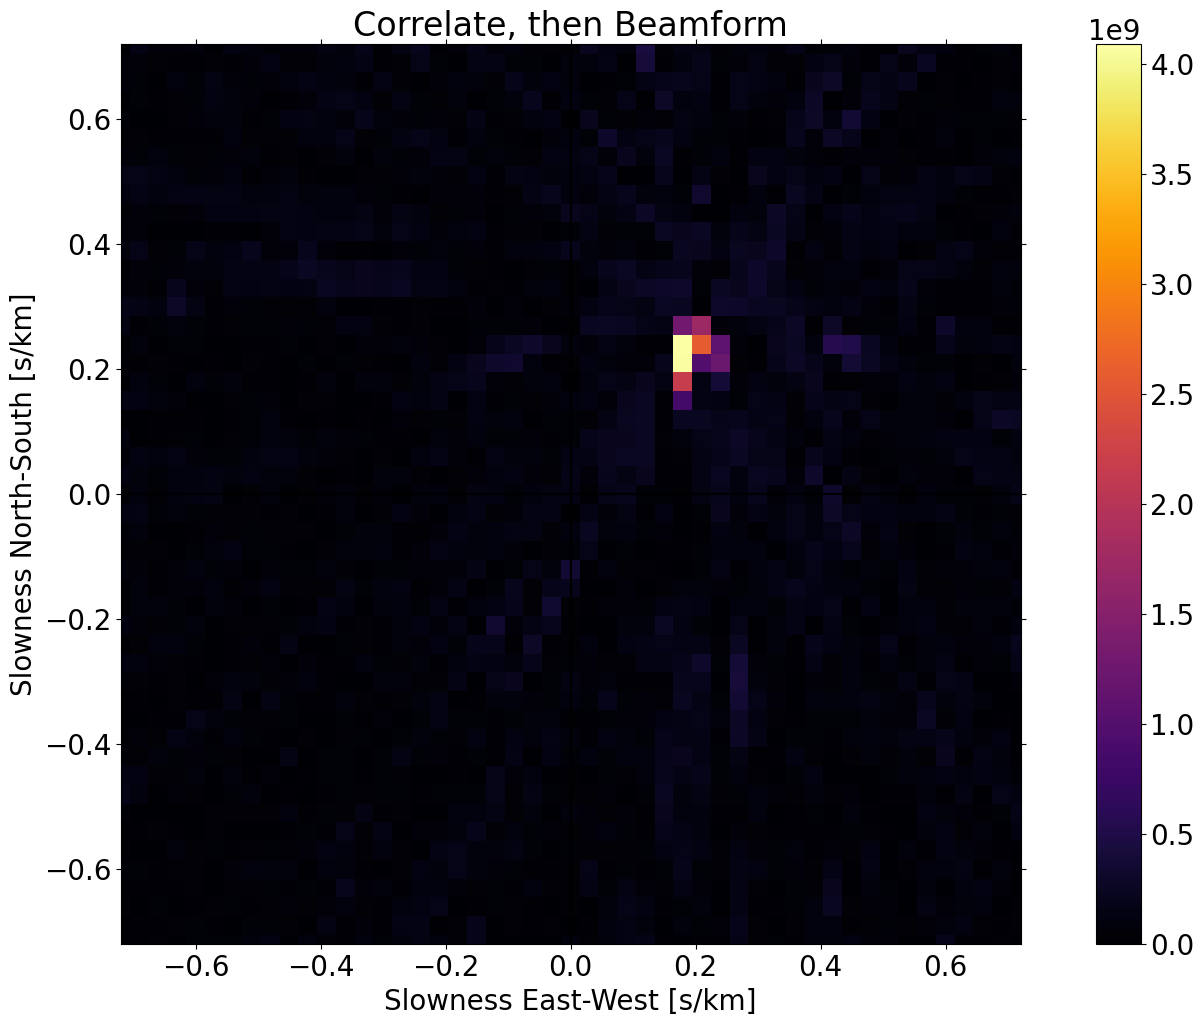

In [16]:
P3 = np.zeros([nux,nuy])

counter_grid = 0
print("starting gridpoints: {0}".format(nux*nuy))
for ix in range(0,nux):
        for iy in range(0,nuy):
                counter_grid+=1
                if(counter_grid % 1000 == 0):
                    print(counter_grid)
                    
               # For each station-station pair
                counter = 0
                for i in range(0,nsta):
                    for j in range(0,nsta):

                         # Ignore auto-correlations
                        if(i==j):
                            counter += 1
                            continue

                        # Distance vector (in km)
                        distance_x = xx[i]-xx[j]
                        distance_y = yy[i]-yy[j]

                        # effective time, i.e., where signal in correlation shows up
                        time_effective = -ux[ix]*distance_x -uy[iy]*distance_y

                        index_time = (np.abs(tt - time_effective)).argmin()
                        P3[ix,iy] += cct[index_time,counter]
                        
                        counter += 1
print('done!')
plot_beam(P3,title="Correlate, then Beamform",save=1,savename="correlation_beamform_3.pdf")


## Array Response Function
### This is a way of seeing how well the array can resolve a given frequency; how much smearing or aliasing is present. This is based on Equation 30 in Rost and Thomas, 2002, but in slowness domain instead of wavenumber domain.

\begin{equation*}
A(sx,sy) = \frac{1}{N} \left| \sum_{n}^{nsta} e^{-2 \pi i f \Delta t} \right| \,dt.
\end{equation*}

### The resulting image shows you how aliased or smeared the result will be. A single noise source, for example from the North-West, will appear as a blob of roughly the same pattern as the ARF, only shifted to the North-West
### This particular ARF at 0.0125 Hz is quite smeared. By increasing the frequency, or ultimately by combining frequencies, we can eventually get much better resolution.

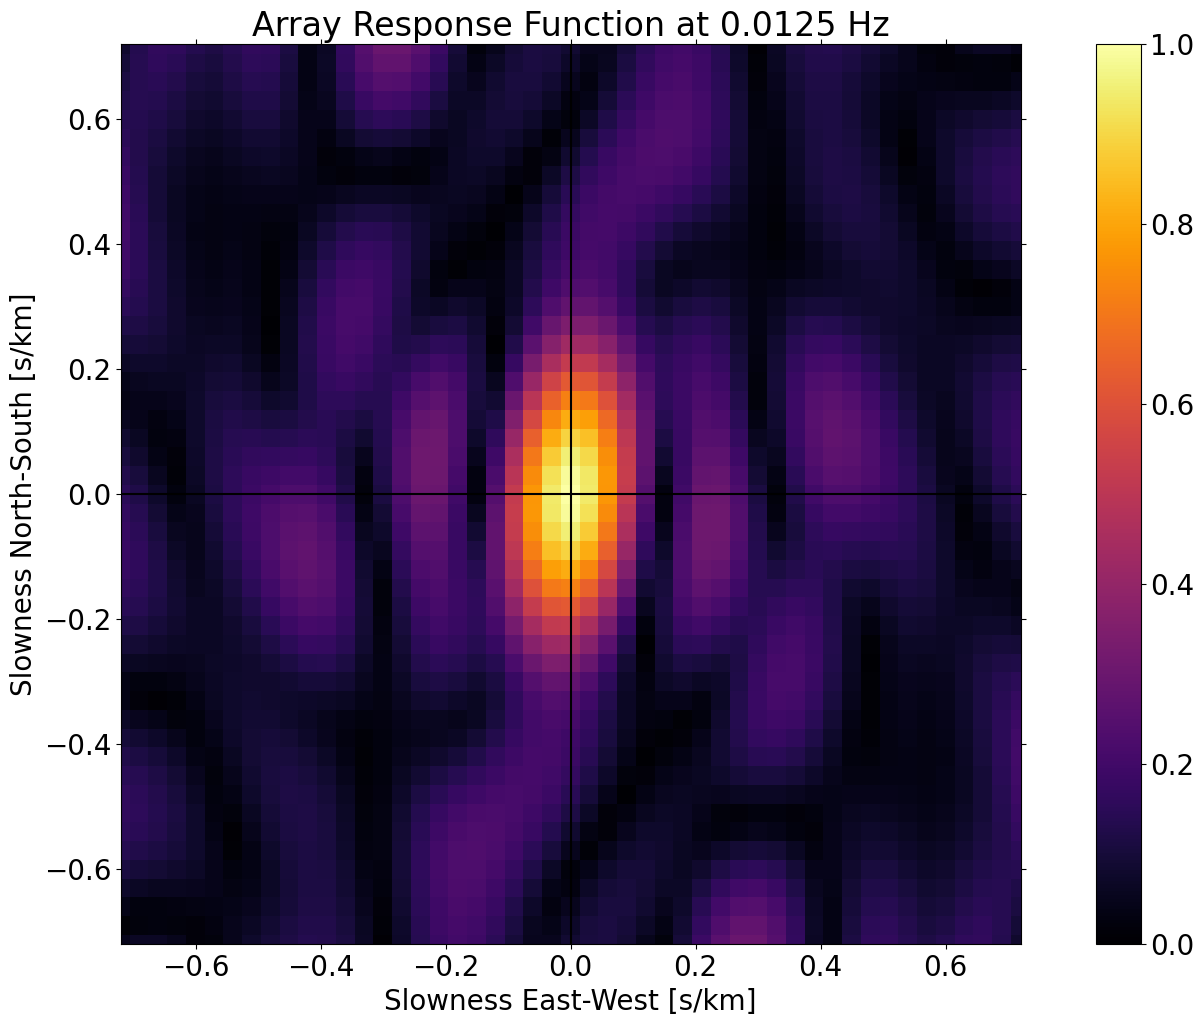

In [17]:
target_f = 0.0125

arf = np.zeros([nux,nuy],dtype=complex)

tlib=np.zeros([nsta,nux,nuy],dtype=float)
for ix in range(0,nux):
        for iy in range(0,nux):
            tlib[:,ix,iy] = xx*ux[ix] + yy*uy[iy]

# Eq 30 in Rost and Thomas, but using slowness domain instead of wavenumber domain
# Instead of applying timeshifts to the data, we forget the data exists and see how 
#  the timeshifts turn into patterns of slowness-domain wavelengths (e^...) and add them up.
for i in range(nsta):
    arf += np.exp(-1j*2*np.pi*target_f*tlib[i,:,:])
arf = arf/nsta
    
plot_beam(np.abs(arf),title="Array Response Function at {0} Hz".format(target_f),save=0,savename="array_response.pdf")


## Polar plotting
### Below is a little script to convert the cartesian gridpoints as above into a polar plot. The physics or interpretation are unchanged, but sometimes the polar plot is nice for readers / viewers to understand that we are conveying a directionality rather than an actual, physical location.

In [18]:
# Polar plotting:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

UX, UY = np.meshgrid(ux, uy)
UR = np.zeros_like(UX)
UT = np.zeros_like(UY)
for iux in range(nux):
    for iuy in range(nuy):
#         UR[iux, iuy], UT[iux, iuy] = cart2pol(UX[iux, iuy], UY[iux, iuy])
        UR[iux, iuy], UT[iux, iuy] = cart2pol(UX[iux, iuy]-dux/2, UY[iux, iuy]-duy/2)
        

def plot_beam_polar(P, title="Beamform",save=0,savename='none',cmin=0,cmax=0,normalize=False,targetbox=False):
    fig = plt.figure(figsize=(15,15))
    #ax = fig.add_subplot(111, polar = True)
    #test_axes=fig.add_axes([0,0,1,1])
    #test_axes.grid(True)
    ax = fig.add_axes([0.1,0.1,0.55,0.55], polar=True)  #x0,y0,dx,dy
    cmap = plt.get_cmap('inferno')

    if(cmax==0):
        cmax=np.max(P)
    if(cmin==0):
        cmin=np.min(P)
    if(normalize):
        P = (P-cmin)/(cmax-cmin)
    
    # Actually plot:
    #i = plt.pcolor(ux-dux/2,uy-duy/2,np.real(P.T),cmap=cmap,rasterized=True)#,vmin=-4,vmax=4)
    i = plt.pcolor(2*np.pi-UT[::1]+np.pi/2, UR[::1], np.real(P[::1]), cmap=cmap, rasterized=True)

    if(normalize):
        plt.clim(0,1)
    else:
        plt.clim(cmin,cmax)
    
    if targetbox:
        angle1 = np.radians(28.0)
        angle2 = np.radians(60.0)
        thetas = np.linspace(angle1, angle2, 100)
        radius1 = 0.26
        radius2 = 0.39
        radii1 = radius1 * np.ones_like(thetas)
        radii2 = radius2 * np.ones_like(thetas)
        plt.plot(thetas, radii1, "w--", linewidth=4)
        plt.plot(thetas, radii2, "w--", linewidth=4)
        plt.plot([angle1, angle1], [radius1, radius2], "w--", linewidth=4)
        plt.plot([angle2, angle2], [radius1, radius2], "w--", linewidth=4)

    
    # set title, labels, etc
    plt.title(title)
    ax.set_xticks(np.arange(0, 2.0*np.pi, np.pi/2.0))
    ax.set_xticklabels(["E", "N", "W", "S"])
    ax.tick_params(axis='x', colors='black', grid_linestyle='--')
    
    ax.set_ylim(0,0.5)
    ax.set_yticks([0.1, 0.2, 0.3, 0.4])
    ax.tick_params(axis='y', colors='white', grid_linestyle='--',labelsize=24)
    ax.text(np.radians(-15), 0.12, 'Slowness [s/km]', rotation=0, color="white",fontsize=24)
    ax.set_rlabel_position(0)
    ax.grid(True)
    

    # colorbar
    #colorbar_ax = fig.add_axes([0.95, 0.25, 0.03, 0.5])  #x0,y0,dx,dy
    # plot has height 0.55. colorbar spans 0.3, remainder 0.25/2=0.125+0.1padding=0.225
    colorbar_ax = fig.add_axes([0.7, 0.225, 0.02, 0.3])  #x0,y0,dx,dy
    if normalize:
        fig.colorbar(i, cax=colorbar_ax, label="Normalized PSD")
    else:
        fig.colorbar(i, cax=colorbar_ax, label="PSD [units?]")
    
    # save figure
    if(save==1):
        plt.savefig(savename, bbox_inches='tight')
    
    plt.show()
    
    

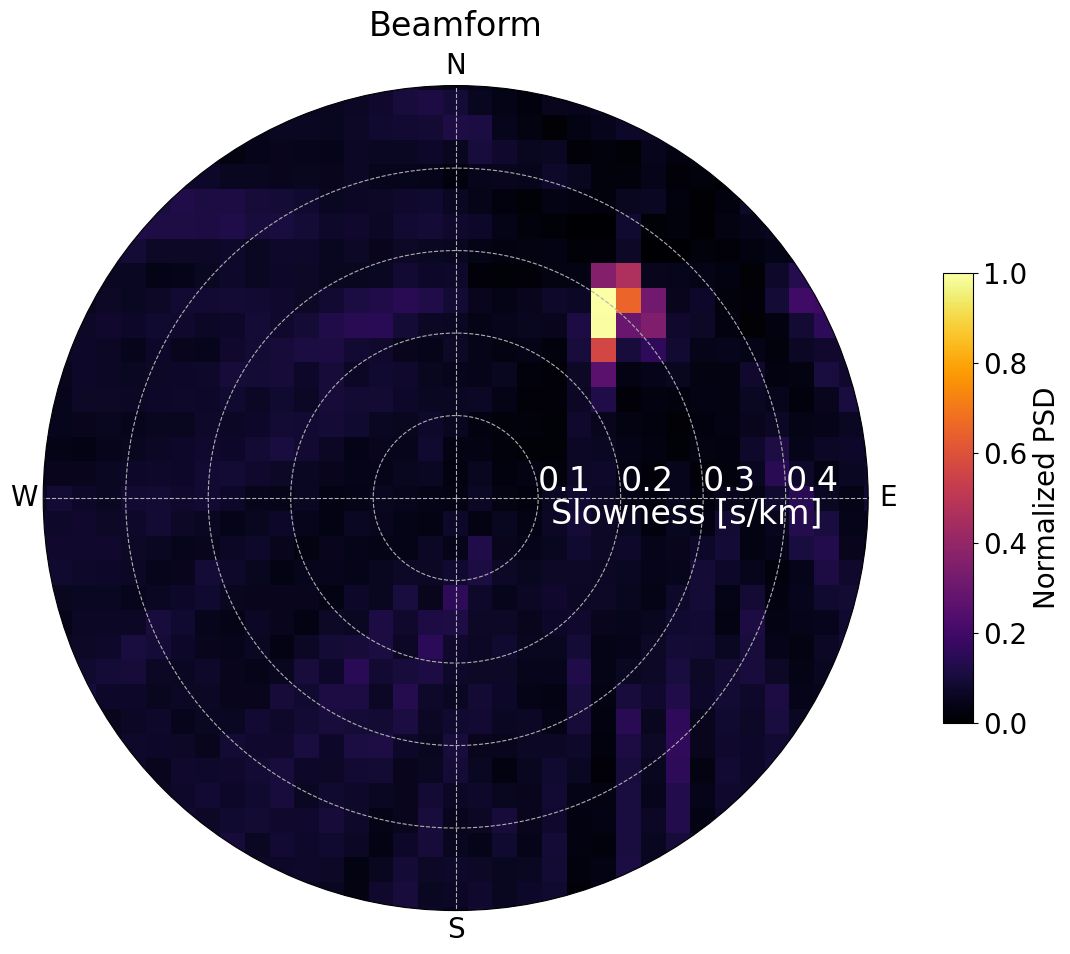

In [19]:
plot_beam_polar(P3, title="Beamform", 
          save=True, savename="beamform_polar.pdf", 
          normalize=True)

## Future work - it's certainly possible to perform the gridsearch in polar coordinates, avoiding this conversion process at the end